In [405]:
import pandas as pd
import importlib
import matplotlib.pyplot as plt
import stumpy
import numpy as np
import sys
import os
import sys
# Add project root to path - adjust the number of parent dirs (..) based on where your notebook is located
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)


from src.datamodule import datamodule
from src.visualization import SessionReplayer, TrajectoryVisualizer
from src.utils import utils, Astar
from src.models import LSTM


importlib.reload(utils)
importlib.reload(datamodule)
importlib.reload(TrajectoryVisualizer)
importlib.reload(LSTM)
# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all"

<module 'src.models.LSTM' from 'c:\\LocalData\\pabflore\\encoder-pacman\\src\\models\\LSTM.py'>

In [391]:
user_df, ip_df, redcap_df, game_df, gamestate_df, psychometrics_df = utils.read_data('../data/')

gamestate_df.columns

Index(['game_state_id', 'game_id', 'time_elapsed', 'score', 'lives',
       'pacman_attack', 'input_direction', 'movement_direction', 'Pacman_X',
       'Pacman_Y', 'Ghost1_X', 'Ghost1_Y', 'Ghost2_X', 'Ghost2_Y', 'Ghost3_X',
       'Ghost3_Y', 'Ghost4_X', 'Ghost4_Y', 'ghost1_state', 'ghost2_state',
       'ghost3_state', 'ghost4_state', 'powerPellets', 'pellets',
       'powerpelletstate_1', 'powerpelletstate_2', 'powerpelletstate_3',
       'powerpelletstate_4', 'fruitState_1', 'fruitState_2'],
      dtype='object')

In [392]:
GAME_ID = 716

GAME_STATE_VARIABLES = ['score', 'powerPellets']
COORDINATES = ['Pacman_X', 'Pacman_Y']
DIRECTION = ['movement_direction']
INPUT = ['input_direction']


pacman_ts = gamestate_df.loc[gamestate_df['game_id'] == GAME_ID][['time_elapsed'] + COORDINATES + DIRECTION]
pacman_ts.reset_index(drop=True, inplace=True)

for col in COORDINATES:
    pacman_ts[col] = pacman_ts[col].astype(float)

# pacman_ts = utils.pos_mirroring(pacman_ts, return_quadrant=True)

pacman_ts.head()

,time_elapsed,Pacman_X,Pacman_Y,movement_direction
0,0.20,0.0,-9.5,none
1,0.25,0.0,-9.5,none
2,0.30,0.0,-9.5,none
3,0.35,0.0,-9.5,none
4,0.39,0.0,-9.5,none


In [393]:
pacman_ts['position_vector'] = list(zip(pacman_ts['Pacman_X'], pacman_ts['Pacman_Y']))

direction_mapping = {
    'right': (1, 0),
    'left': (-1, 0),
    'up': (0, 1),
    'down': (0, -1),
    'none': (0, 0)
}

pacman_ts['movement_vector'] = pacman_ts['movement_direction'].map(direction_mapping)


pacman_ts

,time_elapsed,Pacman_X,Pacman_Y,movement_direction,position_vector,movement_vector
0,0.200000,0.00,-9.50,none,"(0.0, -9.5)","(0, 0)"
1,0.250000,0.00,-9.50,none,"(0.0, -9.5)","(0, 0)"
2,0.300000,0.00,-9.50,none,"(0.0, -9.5)","(0, 0)"
3,0.350000,0.00,-9.50,none,"(0.0, -9.5)","(0, 0)"
4,0.390000,0.00,-9.50,none,"(0.0, -9.5)","(0, 0)"
...,...,...,...,...,...,...
1516,76.000000,-5.84,8.50,right,"(-5.84, 8.5)","(1, 0)"
1517,76.050003,-5.53,8.50,right,"(-5.53, 8.5)","(1, 0)"
1518,76.099998,-5.08,8.50,right,"(-5.08, 8.5)","(1, 0)"
1519,76.139999,-4.80,8.48,right,"(-4.8, 8.48)","(1, 0)"


In [394]:
processed_df = utils.preprocess_game_data(gamestate_df)

processed_df

,game_id,time_elapsed,Pacman_X,Pacman_Y
3955,388,0.190000,1.49,-9.49
3956,388,0.230000,1.94,-9.49
3957,388,0.290000,2.24,-9.50
3958,388,0.330000,2.69,-9.50
3959,388,0.400000,3.00,-9.50
...,...,...,...,...
715289,1045,19.240000,-5.83,8.50
715290,1045,19.290001,-5.32,8.50
715291,1045,19.340000,-4.98,8.50
715292,1045,19.389999,-4.45,8.49


In [395]:
tensordf, mask, game_idx = utils.create_game_trajectory_tensor(processed_df)

In [396]:
tensordf.shape

torch.Size([656, 6320, 3])

In [402]:
data_module = datamodule.TrajectoryDataModule(
            data_folder='../data/',
            batch_size=32,
            max_sequence_length=None,
            series_type=['position'],
            include_game_state_vars=False,
            include_timesteps=True
        )

data_module.prepare_data()
data_module.setup()
train_loader = data_module.train_dataloader()

len(data_module.train_dataset)

for batch in train_loader:
    print(batch['trajectory'].shape)
    print(batch['mask'].shape)
    break

data = next(iter(train_loader))

data['trajectory'][0]


torch.Size([32, 6320, 3])
torch.Size([32, 6320])


tensor([[ 0.2000, -1.4900, -9.4900],
        [ 0.2500, -1.7900, -9.4900],
        [ 0.2900, -2.2400, -9.5000],
        ...,
        [ 0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000]])

In [414]:
data['trajectory'].shape

torch.Size([32, 6320, 3])

In [398]:
# min_x_value = data['trajectory'][:, :, 1].min().item()
# print(f"Min value for x (second feature): {min_x_value}")

# min_y_value = data['trajectory'][:, :, 1].max().item()
# print(f"Max value for x (second feature): {min_y_value}")



In [399]:

# min_y_value = data['trajectory'][:, :, 2].min().item()
# print(f"Min value for y (third feature): {min_y_value}")

# max_y_value = data['trajectory'][:, :, 2].max().item()
# print(f"Max value for y (third feature): {max_y_value}")





In [423]:
model = LSTM.LSTMAutoencoder(
        input_dim=data_module.feature_dimension,
        latent_dim=32,  # Adjust latent dimension as needed
        sequence_length=data_module.sequence_length,
        learning_rate=1e-3
    )


X_hat, z = model(data['trajectory'])

print(X_hat.shape)

print(z.shape)


torch.Size([32, 6320, 3])
torch.Size([32, 32])


In [400]:

visualizer = TrajectoryVisualizer.TrajectoryVisualizer(data_folder="../data/")

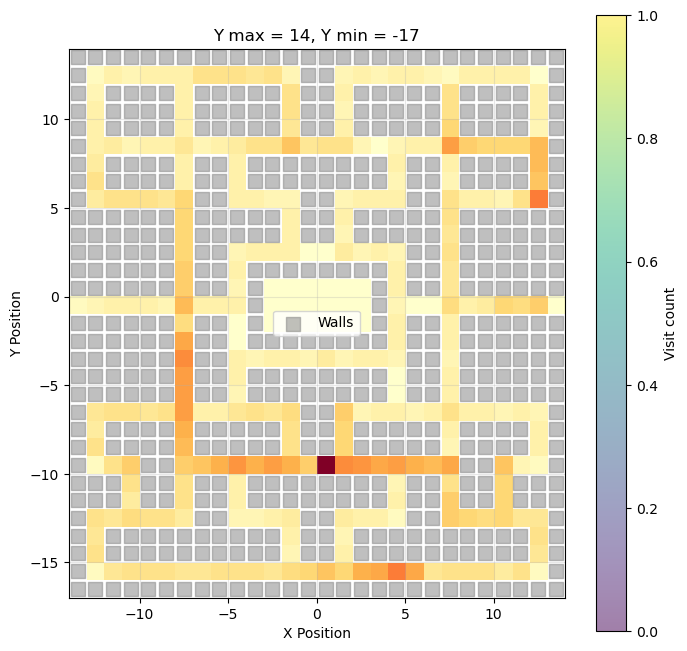

In [401]:
visualizer.create_trajectory_heatmap(game_id=600, normalize=False)